In [1]:
import json 
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import math

In [2]:
def get_results(results, random_counterpart=None, random_concepts=None, num_random_exp=100,
    min_p_val=0.05, name = '', key=True ):
  """Helper function to organize results.
  When run in a notebook, outputs a matplotlib bar plot of the
  TCAV scores for all bottlenecks for each concept, replacing the
  bars with asterisks when the TCAV score is not statistically significant.
  If you ran TCAV with a random_counterpart, supply it here, otherwise supply random_concepts.
  If you get unexpected output, make sure you are using the correct keywords.

  Args:
    results: dictionary of results from TCAV runs.
    random_counterpart: name of the random_counterpart used, if it was used. 
    random_concepts: list of random experiments that were run. 
    num_random_exp: number of random experiments that were run.
    min_p_val: minimum p value for statistical significance
  """
  weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  
    
  # helper function, returns if this is a random concept
  def is_random_concept(concept):
    if random_counterpart:
      return random_counterpart == concept

    elif random_concepts:
      return concept in random_concepts

    else:
      return 'random500_' in concept or 'negative' in concept
    
  def is_weekday(concept):
    return 'weekday' in concept.lower() and not 'negative' in concept.lower()

  # print class, it will be the same for all
#   print("Class =", results[0]['target_class'])

  # prepare data
  # dict with keys of concepts containing dict with bottlenecks
  result_summary = {}
    
  # random
  random_i_ups = {}
  b='dense'
  for result in results:
    b = result['bottleneck']
#     print(result['cav_concept'])
    if result['cav_concept'] not in result_summary:
      result_summary[result['cav_concept']] = {}
    if result['bottleneck'] not in result_summary[result['cav_concept']]:
      result_summary[result['cav_concept']][result['bottleneck']] = []
    result_summary[result['cav_concept']][result['bottleneck']].append(result)
    # store random
    if is_random_concept(result['cav_concept']):
        if result['bottleneck'] not in random_i_ups:
            random_i_ups[result['bottleneck']] = []
        try:
            random_i_ups[result['bottleneck']].append(result['i_up'][0]/result['i_up'][1])
        except:
            random_i_ups[result['bottleneck']].append(result['i_up'])
  # to plot, must massage data again 
  plot_data = {}
  plot_concepts = []
  # print concepts and classes with indentation
  day_scores =[]
  day_stds = []
  day_cts = []

  for concept in result_summary.keys():
#     print(concept)
    if (not is_random_concept(concept) or not (random_concepts==None)):
#       print("!", "Concept =", concept)
      plot_concepts.append(concept)
      print(concept,np.mean([x['cav_accuracies']['overall'] for x in result_summary[concept][b] ]))

      for bottleneck in result_summary[concept]:
        if is_weekday(concept):
            i_ups = [item['i_up'][0]/item['i_up'][1] for item in result_summary[concept][bottleneck]]
        else:
            i_ups = [item['i_up'] for item in result_summary[concept][bottleneck]]
        b=bottleneck
        # Calculate statistical significance
        _, p_val = ttest_ind(random_i_ups[bottleneck], i_ups)
  
        if bottleneck not in plot_data:
          plot_data[bottleneck] = {'bn_vals': [], 'bn_stds': [], 'significant': []}
        try:
            if False:#p_val > min_p_val:
              # statistically insignificant
              plot_data[bottleneck]['bn_vals'].append(0.01)
              plot_data[bottleneck]['bn_stds'].append(0)
              plot_data[bottleneck]['significant'].append(False)
            else:
              plot_data[bottleneck]['bn_vals'].append(np.mean(i_ups))
              plot_data[bottleneck]['bn_stds'].append(np.std(i_ups))
              plot_data[bottleneck]['significant'].append(True)
        except:
            print('ERROR!!!!!!!!!!!!!!!!',concept)
#   if any(['monday' in x.lower() for x in result_summary]):
#     print('!!!!')
#     plot_concepts.append('weekday')
#     plot_data[b]['bn_vals'].append(np.mean(day_scores))#sum(day_scores)/sum(day_cts))
#     plot_data[b]['bn_stds'].append(1/sum(np.square(np.array([1/x for x in day_stds]))))#np.std(day_scores))
# #     
    
  return plot_data, plot_concepts



In [21]:
targets = [x for x in os.listdir('results/') if x.startswith('mortality_filtered_disch') and 'distilbert' in x and 'tokenize' not in x]
concepts = [x.split('_')[5] for x in targets]

In [22]:
targets.pop(2)
concepts.pop(2)

'5.json'

In [23]:
concepts

['Wednesdaydistilbert',
 'mechvent',
 'temp',
 'resprate',
 'Sundaydistilbert',
 'preiculos',
 'age',
 'electivesurgery',
 'gcs',
 'Saturdaydistilbert',
 'urineoutput',
 'Mondaydistilbert',
 'heartrate',
 'Thursdaydistilbert',
 'Tuesdaydistilbert',
 'meanbp',
 'Fridaydistilbert']

In [24]:
scores_dir = 'results/'
num_epochs = len(os.listdir(scores_dir))
import re
def plot_multiple(targets, relative=True):
    heights = []
    errs=[]
    for i,target in enumerate(targets):
        epoch_scores = []
        fn=target
    #     dicts = eval(open(scores_dir+fn, 'r').read())
    #         results = get_results(dicts, random_concepts= ['n2c2_CAD', 'n2c2_DIABETES', 'n2c2_MEDICATION', 'n2c2_HYPERTENSION', 'n2c2_FAMILY_HIST', 'n2c2_SMOKER', 'n2c2_HYPERLIPIDEMIA', 'n2c2_OBESE'] )
        dicts = open(scores_dir+target, 'r').read()

    #     dicts=dicts.replace('WEEKDAY_discharge_','')
#         dicts=dicts.replace('WEEKDAY_discharge_','')
#         dicts=dicts.replace('filtered_disch_','filtered_')
        dicts = eval(dicts)
        print(len(dicts))
        weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  
    #     weekdays = ['WEEKDAY_discharge'+x for x in weekdays]
        if relative:
            results = get_results(dicts, random_concepts=concepts+weekdays  )
        else:
            results = get_results(dicts, num_random_exp=math.sqrt(len(dicts)))
    #         results = get_results(dicts, random_concepts=  ['mimic_exclusiveHYPERTENSION', 'mimic_exclusiveDIABETES', 'mimic_exclusiveSMOKER', 'mimic_exclusiveHYPERLIPIDEMIA', 'mimic_exclusiveOBESE', 'mimic_exclusiveMEDICATION']   )
    #         results = get_results(dicts, random_concepts=   ['cat_mimic_exclusiveDIABETES', 'cat_mimic_exclusiveHYPERLIPIDEMIA', 'cat_mimic_exclusiveHYPERTENSION', 'cat_mimic_exclusiveMEDICATION', 'cat_mimic_exclusiveOBESE', 'cat_mimic_exclusiveSMOKER']    )
        epoch_scores.append({k:(v,q) for k,v,q in zip(results[1],results[0][list(results[0].keys())[0]]['bn_vals'] ,results[0][list(results[0].keys())[0]]['bn_stds'])})

        epoch_scores = {k: v for d in epoch_scores for k, v in d.items()}

        epoch_scores=dict(sorted(epoch_scores.items()))
        concept_labels = epoch_scores.keys()
    #     return concept_labels
        concept_labels = [x.split('-') for x in concept_labels]
        for i, label in enumerate(concept_labels):
            if all([ x.isnumeric() for x in label[-5:-1]]) and len(label)>3:
                newlabel = '-'.join(label[:-5]+[label[-5]+'.' + label[-4]] +[label[-3]+'.'+label[-2]])
                concept_labels[i] = newlabel
            else:
                if all([ x.isnumeric() for x in label[-2:]]) :
                    newlabel = '-'.join(label[:-2]+[label[-2]+'.' + label[-1]])
                    concept_labels[i] = newlabel
                else:   
                    concept_labels[i] = '-'.join(label)


        high_concepts = [concept_labels[i] for i,x in enumerate(epoch_scores.items()) if x[1][0] >0.5]
        high_scores = [x[1][0] for i,x in enumerate(epoch_scores.items()) if x[1][0] >0.5]
        # pd.DataFrame(zip(high_concepts, high_scores)).to_csv()
        scores = [x[1][0] if x[1][0] >0.1 else '' for i,x in enumerate(epoch_scores.items()) ]
#         errs = [x[1][1] if x[1][0] >0.1 else '' for i,x in enumerate(epoch_scores.items()) ]

    #     pd.DataFrame(zip(concept_labels,scores,errs )).to_csv('plots/scores_bert'+target+'_first.csv',header = ['category','TCAV', 'stdev'])

        # plt.tight_layout()
        heights.append( [v[0] for v in epoch_scores.values()][0])
#         print(concepts[i],str(dicts)[:500],heights)
        errs.append([v[1] for v in epoch_scores.values()][0])
        
    fig, ax = plt.subplots(figsize=(3,len(heights)))
    ax.barh(range(len(heights)),heights, xerr=errs)
    plt.yticks(range(len(heights)),range(len(heights)))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        # ax.text(1.05, 1, '\n'.join([str(i)+' '+phe for i,phe in enumerate(epoch_scores[0].keys())]), transform=ax.transAxes, fontsize=14,
        #         verticalalignment='top', bbox=props)
    ax.invert_yaxis()
    ax.set_yticklabels(concepts, fontsize=16)
    for i, v in enumerate(heights):
        ax.text(0.05, i+0.15, str(v)[:5], color='black', fontweight='bold', fontsize = 14)
    plt.xlabel('TCAV score')
    plt.ylabel('Clinical Concept')        
    plt.title('Regular TCAV Scores for Distilbert \n30day post-discharge mortality prediction\n based on Discharge Summaries')
    plt.savefig('plots/tcav_'+target.split('/')[-1]+'.pdf', bbox_inches = "tight")
#     plt.show()

100
WEEKDAY_discharge_Wednesday 0.5163636363636364
100
filtered_disch_mechvent_score 0.5598075998075999
9
filtered_disch_temp_score 0.6943079443079444
16
filtered_disch_resprate_score 0.6356060606060606
100
WEEKDAY_discharge_Sunday 0.543939393939394
4
filtered_disch_preiculos_score 0.6139146567717997
9
filtered_disch_age_score 0.9078746650175221
4
filtered_disch_electivesurgery_score 0.5867638650657518
100
filtered_disch_gcs_score 0.6024242424242424
100
WEEKDAY_discharge_Saturday 0.5518181818181819
36
filtered_disch_urineoutput_score 0.581010101010101
100
WEEKDAY_discharge_Monday 0.5296969696969697
25
filtered_disch_heartrate_score 0.5877427334570191
100
WEEKDAY_discharge_Thursday 0.5248484848484849
100
WEEKDAY_discharge_Tuesday 0.5157575757575757
64
filtered_disch_meanbp_score 0.6312144886363636
100
WEEKDAY_discharge_Friday 0.5324242424242425


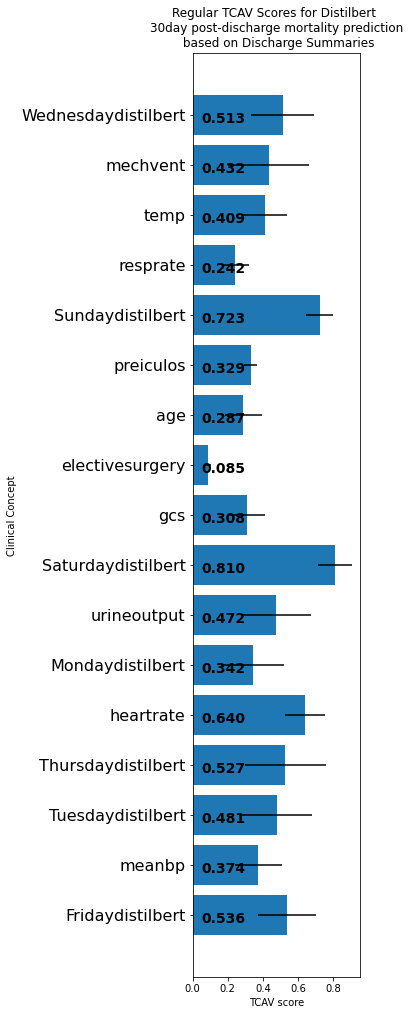

In [25]:
plot_multiple(targets, relative=False)

# 